<a href="https://colab.research.google.com/github/akshaybankapure/Skin-Cancer-Classification-using-Deep-Learning/blob/main/Diagnosing%20Skin%20Cancer%20using%20Deep%20Learning%20and%20visualisation%20Gradcam%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

installing the necessory pyton libraries

In [ ]:
#!pip install keras.applications

importing major libraries

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
#from keras.utils import to_categorical #tf.keras.utils.to_categorical
import tensorflow as tf
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
%matplotlib inline

We will mount the drive to retieve the data, as we are getting the data from the drive it

In [2]:
!mkdir "ISIC_2019"
######ATTACHING GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

mkdir: cannot create directory ‘ISIC_2019’: File exists
Mounted at /content/drive


In [ ]:
#!cp "drive/MyDrive/Data/ISIC_2019/X.npy" -r "./"

In [6]:
#EXECUT ONLY FIRST TIME
!unzip -q "drive/MyDrive/Data/ISIC_2019_Training_Input.zip" -d "ISIC_2019"
!cp "drive/MyDrive/Data/ISIC_2019/ISIC_2019_Training_GroundTruth.csv" -r "./ISIC_2019"

In [3]:
import pandas as pd
import tensorflow.keras as keras

In [4]:
data_frame = pd.read_csv("ISIC_2019/ISIC_2019_Training_GroundTruth.csv")
data_frame = data_frame.drop("UNK", axis=1)
data_frame["image"] = data_frame["image"].apply(lambda x: x + ".jpg")
data_frame.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC
0,ISIC_0000000.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
#Took help from Jacob Carse
splits = [0.5, 0.2, 0.3]
splits = [int(i * data_frame.shape[0]) for i in splits]
data_frame = data_frame.sample(frac=1).reset_index(drop=True)
train_df = data_frame.iloc[0:splits[0], :]
val_df = data_frame.iloc[splits[0]:splits[0] + splits[1], :]
test_df = data_frame.iloc[splits[0] + splits[1]:, :]


In [9]:
train_df.count()

image    12665
MEL      12665
NV       12665
BCC      12665
AK       12665
BKL      12665
DF       12665
VASC     12665
SCC      12665
dtype: int64

In [10]:
train_df.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC
0,ISIC_0064753.jpg,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0072016.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0072484.jpg,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,ISIC_0032021.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0056614.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
train_df.columns

Index(['image', 'MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC'], dtype='object')

Need to manage the RAM SO saving the np array to disk

In [ ]:
'''import numpy as np;
import time; 
from tempfile import TemporaryFile

file = TemporaryFile()
np.savez(file,a = a, b = b, c = C)'''

In [6]:
# Convert Wide to Long Format
dfGT = data_frame
df_trf = pd.melt(dfGT, id_vars='image', var_name='diagnosis', value_name='value').\
    sort_values('image').\
    reset_index(drop=True)

# Select rows when diagnosis == 1
df_trf = df_trf[df_trf['value'] == 1]
df_trf.drop('value', inplace=True, axis = 1)
df_trf.reset_index(inplace = True, drop = True)

In [7]:
#lets reduce the size even smaller
splits = [0.4, 0.2, 0.4]
splits = [int(i * train_df.shape[0]) for i in splits]
train_df = train_df.sample(frac=1).reset_index(drop=True)
train_df_smaller = train_df.iloc[0:splits[0], :]
val_df_smaller = train_df.iloc[splits[0]:splits[0] + splits[1], :]
test_df_smaller = train_df.iloc[splits[0] + splits[1]:, :]

In [12]:
train_df_smaller.count()

image    5066
MEL      5066
NV       5066
BCC      5066
AK       5066
BKL      5066
DF       5066
VASC     5066
SCC      5066
dtype: int64

In [8]:
dfGT = train_df
df_trf_smaller = pd.melt(dfGT, id_vars='image', var_name='diagnosis', value_name='value').\
    sort_values('image').\
    reset_index(drop=True)

# Select rows when diagnosis == 1
df_trf_smaller = df_trf_smaller[df_trf_smaller['value'] == 1]
df_trf_smaller.drop('value', inplace=True, axis = 1)
df_trf_smaller.reset_index(inplace = True, drop = True)

In [9]:
#lets reduce the size even smaller
splits = [0.5, 0.2, 0.3]
splits = [int(i * df_trf_smaller.shape[0]) for i in splits]
df_trf_smaller = df_trf_smaller.sample(frac=1).reset_index(drop=True)
train_dftrf_smaller = df_trf_smaller.iloc[0:splits[0], :]
val_dftrf_smaller = df_trf_smaller.iloc[splits[0]:splits[0] + splits[1], :]
test_dftrf_smaller = df_trf_smaller.iloc[splits[0] + splits[1]:, :]

In [57]:
train_dftrf_smaller['diagnosis'].value_counts()

NV      3220
MEL     1181
BCC      827
BKL      625
AK       208
SCC      146
DF        64
VASC      61
Name: diagnosis, dtype: int64

In [58]:
test_dftrf_smaller['diagnosis'].value_counts()

NV      1938
MEL      645
BCC      483
BKL      434
AK       130
SCC       98
VASC      37
DF        35
Name: diagnosis, dtype: int64

In [59]:
val_dftrf_smaller['diagnosis'].value_counts()

NV      1255
MEL      463
BCC      327
BKL      267
AK       106
SCC       60
DF        29
VASC      26
Name: diagnosis, dtype: int64

In [10]:
train_image = [] 
#CREDITS: https://www.analyticsvidhya.com/blog/2019/04/build-first-multi-label-image-classification-model-python/
for i in tqdm(range(train_df_smaller.shape[0])):
    img = image.load_img('ISIC_2019/ISIC_2019_Training_Input/'+train_df_smaller['image'][i],target_size=(400,400,3))
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
#X = np.array(train_image)
X = np.array(train_image)
#np.save('X.npy', X)


100%|██████████| 5066/5066 [01:31<00:00, 55.56it/s]


In [11]:
print(X.shape)

(5066, 400, 400, 3)


**Storing 10132 Images (np array) for train and test** because of the size of the images and not be able to save the 

YET TO WORK ON THIS

In [ ]:
#numpy.savetxt(fname, X, fmt=’%.18e’, delimiter=’ ‘, newline=’\n’, header=”, footer=”, comments=’# ‘, encoding=None)

In [ ]:
#!cp "X.npy" -r "drive/MyDrive/Data/ISIC_2019/"
#!cp "drive/MyDrive/Data/ISIC_2019/X.npy" -r "./"

In [ ]:
#X = np.load('X.npy')

In [17]:
X.shape

(5066, 400, 400, 3)

In [20]:
plt.imshow(X[1])

In [56]:
# Puttung the data in the column
newdf = train_df_smaller
df_trf = pd.melt(newdf, id_vars='image', var_name='diagnosis', value_name='value').\
    sort_values('image').\
    reset_index(drop=True)

# Select rows when diagnosis == 1
df_trf = df_trf[df_trf['value'] == 1]
df_trf.drop('value', inplace=True, axis = 1)
df_trf.reset_index(inplace = True, drop = True)

In [24]:
df_trf['diagnosis'][2]


'MEL'

In [21]:
y = np.array(train_df_smaller.drop(['image'],axis=1))
#y = tf.one_hot(y)
y.shape

(5066, 8)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [ ]:
'''# Importing the important libraries
#from keras.applications.resnet50 import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
#from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

# Download the architecture of ResNet50 with ImageNet weights
base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')

# Taking the output of the last convolution block in ResNet50
x = base_model.output


# Adding a Global Average Pooling layer
x = GlobalAveragePooling2D()(x)

# Adding a fully connected layer having 1024 neurons
x = Dense(1024, activation='relu')(x)

# Adding a fully connected layer having 2 neurons which will
# give the probability of image having either dog or cat
predictions = Dense(2, activation='softmax')(x)

# Model to be trained
model = Model(inputs=base_model.input, outputs=predictions)

# Training only top layers i.e. the layers which we have added in the end
for layer in base_model.layers:
    layer.trainable = False

# Compiling the model
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics = ['accuracy'])

# Creating objects for image augmentations
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

# Proving the path of training and test dataset
# Setting the image input size as (224, 224)
# We are using class mode as binary because there are only two classes in our data
training_set = train_datagen.flow_from_directory('training_set',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('test_set',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

# Training the model for 5 epochs
model.fit_generator(training_set,
                         steps_per_epoch = 8000,
                         epochs = 5,
                         validation_data = test_set,
                         validation_steps = 2000)

# We will try to train the last stage of ResNet50
for layer in base_model.layers[0:143]:
  layer.trainable = False

for layer in base_model.layers[143:]:
  layer.trainable = True

# Training the model for 10 epochs
model.fit_generator(training_set,
                         steps_per_epoch = 8000,
                         epochs = 10,
                         validation_data = test_set,
                         validation_steps = 2000)

# Saving the weights in the current directory
model.save_weights("resnet50_weights.h5")

# Predicting the final result of image
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('cat_or_dog_test.jpg', target_size = (224, 224))
test_image = image.img_to_array(test_image)\

# Expanding the 3-d image to 4-d image.
# The dimensions will be Batch, Height, Width, Channel
test_image = np.expand_dims(test_image, axis = 0)

# Predicting the final class
result = model.predict(test_image)[0].argmax()

# Fetching the class labels
labels = training_set.class_indices
labels = list(labels.items())

# Printing the final label
for label, i in labels:
    if i == result:
        print("The test image has: ", label)
        break'''

In [ ]:
'''tf.keras.applications.ResNet50(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000
)
tf.keras.optimizers.SGD'''

In [23]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(400,400,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='sigmoid'))


In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 396, 396, 16)      1216      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 198, 198, 16)      0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 198, 198, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 194, 194, 32)      12832     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 97, 97, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 97, 97, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 93, 93, 64)       

In [14]:
from numpy.random import seed
seed(42)
import tensorflow
tensorflow.random.set_seed(42)
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import argparse
import random
import pickle
import cv2
import os
import itertools
import tensorflow as tf



# import the necessary packages
from keras.models import Sequential
#from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

from sklearn import metrics
import seaborn as sns

import matplotlib.pyplot as plt
#parser.add_argument('-f')
# construct the argument parse and parse the arguments
ap = argparse.ArgumentParser()
#ap.add_argument("-d", "--dataset", default='ISIC_2019/ISIC_2019_Training_Input',
#	help="path to input dataset (i.e., directory of images)")
#ap.add_argument("-m", "--model", default='./models/fashion.h5',
#	help="path to output model")
#ap.add_argument("-l", "--labelbin", default='lb.pickle',
#	help="path to output label binarizer")
ap.add_argument("-f", "--file", required=True) 

args = vars(ap.parse_args())

# initialize the number of epochs to train for, initial learning rate,
# batch size, and image dimensions
EPOCHS = 100
INIT_LR = 1e-3
BS = 40
# gray_scale

# grab the image paths and randomly shuffle them
print("[INFO] loading images...")


[INFO] loading images...



```
# This is formatted as code
model.fit_generator(aug.flow(X_train, Y_train, batch_size=BS),validation_data=(testX, testY),
	steps_per_epoch=len(trainX) // BS,
	epochs=100, verbose=1,shuffle = False)
History =

```





In [ ]:
'''import keras
from keras import backend as K

# Define our custom loss function
def focal_loss(y_true, y_pred):
    gamma = 2.0
    alpha = 0.25
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))

# Compile our model (rem:loss='binary_crossentropy')
adam = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer='adam', loss=[focal_loss], metrics=['accuracy'])'''

In [26]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
H = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=64)

In [33]:
#TEMPORARY FOR SAVING FILES SEPERATELY AFTER EVERY ITERATION
import random
a=random.randint(1,100)


# compile the model using binary cross-entropy rather than
# categorical cross-entropy -- this may seem counterintuitive for
# multi-label classification, but keep in mind that the goal here
# is to treat each output label as an independent Bernoulli
# distribution
#model.compile(loss="categorical_crossentropy", optimizer=opt,
#	metrics=["accuracy"])

# print summary
#print(model.summary())

# train the network
print("[INFO] training network...")
#H = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=64)
# save the model to disk
print("[INFO] serializing network...")
'''model.save("model",
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True,)'''



# TO SHOW ACCURACY and TRAINING LOSS
# Show LEAARNIN PROCESS
plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.figure(figsize=(10,10))
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
plt.show()
plt.savefig(r'drive/MyDrive/NwApResults/plot1_%s.png'%a)
plt.figure(figsize=(10,10))
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()
plt.savefig(r'drive/MyDrive/NwApResults/plot2_%s.png'%a)
plt.figure(figsize=(10,10))
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="upper right")
plt.show()
plt.savefig(r'drive/MyDrive/NwApResults/plot3_%s.png'%a)



def plot_confusion_matrix(cm, classes,
                          normalize= False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize =25)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    sns.set(font_scale=1.0)
    label_font = {'size':'10'} 
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize =8)
    plt.xlabel('Predicted label',fontsize =8 )

# Predict the values from the validation dataset
predsY = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(predsY,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
plt.figure(figsize=(12,12))

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 


# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = [ 'AK',  'BCC', 'BKL', 'DF', 'MEL',
                'NV','SSC','VASC']) 
plt.show()

plt.savefig(r'drive/MyDrive/NwApResults/confusion%s.png'%a)


np.diag(confusion_mtx).sum()/confusion_mtx.sum().sum()
for i in range (confusion_mtx.shape[0]):
    TP= confusion_mtx[i,i]
    FP= confusion_mtx[i,:].sum()- TP
    FN= confusion_mtx[:,i].sum()- TP
    TN = confusion_mtx.sum().sum()-TP-FP-FN
    Accuracy = (TP+TN)/confusion_mtx.sum().sum()
    Precision = TP/(TP+FP)
    Recall = TP/(TP+FN)
    Sensitivity = TP/(TP+FN)
    Specificity = TN/(TN+FP)
    F1_score = (2 * Precision * Recall)/(Precision+Recall)
    print (confusion_mtx[i],Accuracy,Precision,Recall,Sensitivity,Specificity,F1_score)
    target_names = [ 'AK',  'BCC', 'BKL', 'DF', 'MEL',
                'NV','SSC','VASC']
    df=  pd.DataFrame(classification_report(Y_true,Y_pred_classes, target_names = target_names , output_dict= True)).T
    df.to_csv(r'drive/MyDrive/NwApResults/df%s.csv'%a)

[INFO] training network...
[INFO] serializing network...
INFO:tensorflow:Assets written to: model/assets
[ 61 153  42   7  16   2   0   2] 0.8085526315789474 0.21554770318021202 0.46923076923076923 0.46923076923076923 0.8402877697841726 0.2953995157384988
[ 28 657  53   3  22   1   0   0] 0.7335526315789473 0.8599476439790575 0.6879581151832461 0.6879581151832461 0.8106194690265487 0.7643979057591622
[14 48 99 13 22  0  1  0] 0.8032894736842106 0.5025380710659898 0.33 0.33 0.919672131147541 0.3983903420523139
[ 3 11 23  2  3  0  0  1] 0.9552631578947368 0.046511627906976744 0.06896551724137931 0.06896551724137931 0.9725016767270288 0.05555555555555555
[21 65 50  0 25  0  1  0] 0.8631578947368421 0.15432098765432098 0.2604166666666667 0.2604166666666667 0.9037921348314607 0.1937984496124031
[1 7 4 0 3 0 0 1] 0.9875 0.0 0.0 0.0 0.989452867501648 nan
[0 6 8 0 0 0 0 0] 0.9888157894736842 0.0 0.0 0.0 0.990771259063942 nan
[ 2  8 21  4  5  0  1  0] 0.9703947368421053 0.0 0.0 0.0 0.9729551451

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars


In [ ]:
#!mkdir 'drive/MyDrive/new'

saving the model

In [35]:
model.save('./mycanmodelcc400more%s.h5'%a)

In [36]:
model.compiled_metrics == None
model.save('drive/MyDrive/new/mycanmodelcc400more%s.h5'%a)

PLOTTING THE GRAPHS for understanding the 

In [34]:
from numpy.random import seed
seed(42)
import tensorflow
tensorflow.random.set_seed(42)
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import argparse
import random
import pickle
import cv2
import os
import itertools
import tensorflow as tf



# import the necessary packages
from keras.models import Sequential
#from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

from sklearn import metrics
import seaborn as sns

import matplotlib.pyplot as plt

# **The GradCam**

loading the model

In [39]:
#execute only first time
!cp 'drive/MyDrive/new/mycanmodelcc400more87.h5' -r './'

In [40]:
from keras.models import load_model

model = load_model('mycanmodelcc400more%s.h5'%a)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 396, 396, 16)      1216      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 198, 198, 16)      0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 198, 198, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 194, 194, 32)      12832     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 97, 97, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 97, 97, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 93, 93, 64)       

In [41]:
!mkdir "testdata"

The gradcam Algorithm

In [43]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [54]:
import os

img_path = "ISIC_2019/ISIC_2019_Training_Input/" + os.listdir("ISIC_2019/ISIC_2019_Training_Input/")[4]

# We preprocess the image into a 4D tensor
from keras.preprocessing import image
import numpy as np
#img = image.load_img('ISIC_2019/ISIC_2019_Training_Input/'+test_df_smaller['image'][i],target_size=(150,150))
img = image.load_img(img_path, target_size=(400, 400,3))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

# Its shape is (1, 150, 150, 3)
print(img_tensor.shape)

(1, 400, 400, 3)


In [55]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In [49]:
from keras import models

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [50]:
# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_tensor)

In [51]:
first_layer_activation = activations[0]
last_layer_activation = activations[7]

print(first_layer_activation.shape)
print(last_layer_activation.shape)

(1, 396, 396, 16)
(1, 46, 46, 64)


In [52]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


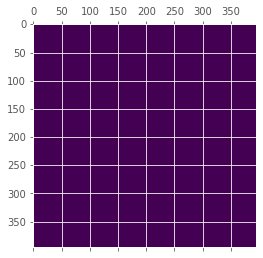

In [45]:
plt.matshow(first_layer_activation[0, :, :, 8], cmap='viridis')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


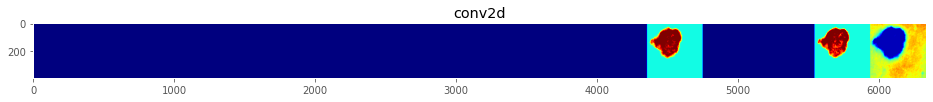

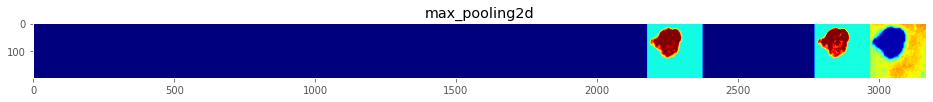

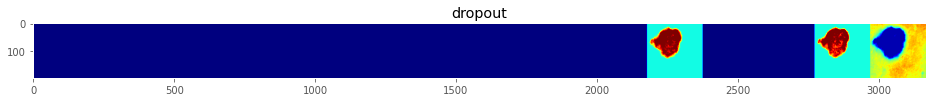

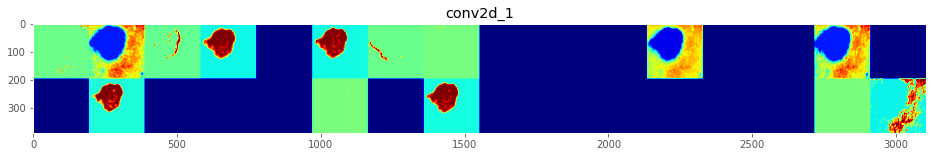

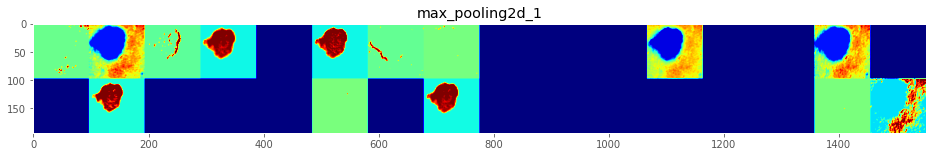

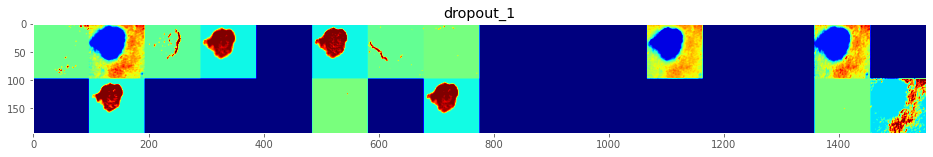

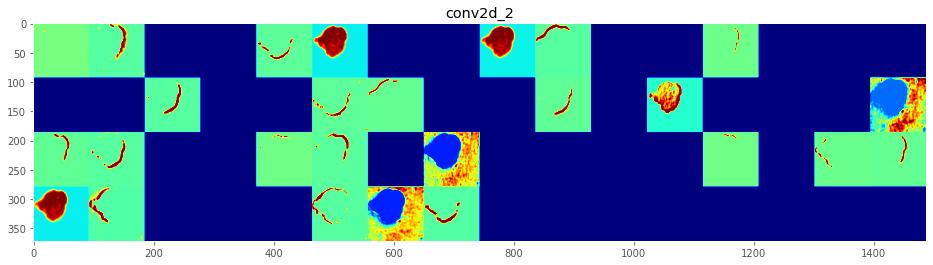

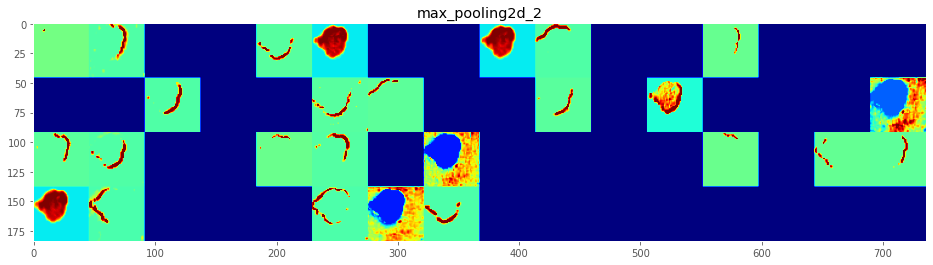

In [46]:
import keras

# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='jet')
    
plt.show()

In [ ]:
!pip install gradcam 

===========================================================================================

In [53]:
!mkdir "itesting1"

In [54]:
!cp "drive/MyDrive/image_test/ISIC_0034322.jpg" -r "itesting1"

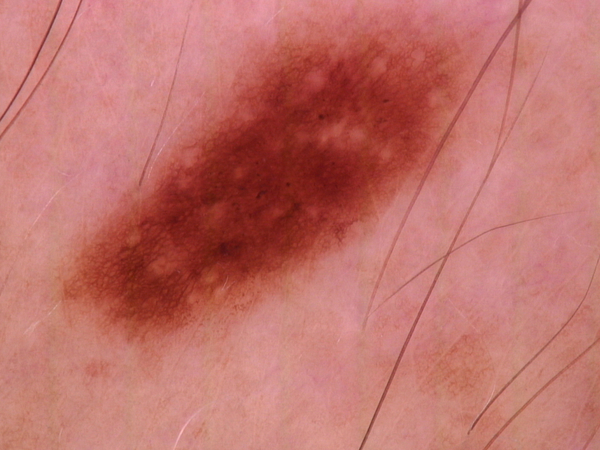

In [55]:
from IPython.display import Image, display

model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

# The local path to our target image
img_path = "itesting1/ISIC_0034322.jpg"
display(Image(img_path))

49152/35363 [=========================================] - 0s 0us/step
Predicted: [('n01776313', 'tick', 8.0645075)]


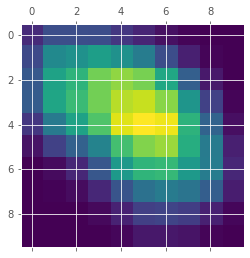

In [56]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

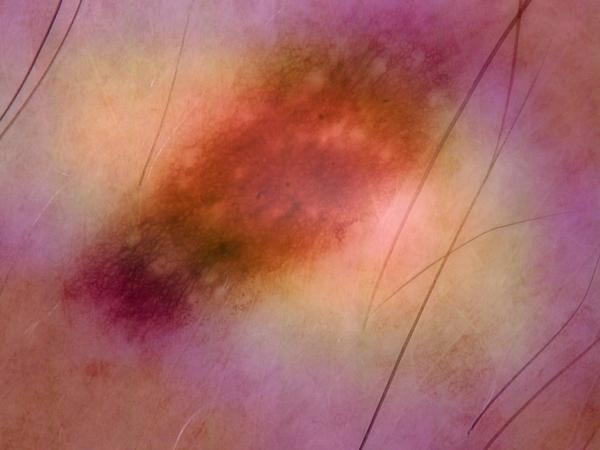

In [57]:
import matplotlib.cm as cm
#https://keras.io/examples/vision/grad_cam/
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("gist_earth")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

=============================================================================

In [ ]:
import cv2

# We use cv2 to load the original image
img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img

# Save the image to disk
cv2.imwrite('elephant_cam.jpg', superimposed_img)